In [1]:
import sys
sys.path.append('..')
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset
from tqdm import tqdm

In [2]:
def get_datapoint(dims, batch_size):
    target = torch.randint(2, size=(batch_size,))
    trace = torch.randn(batch_size, dims) + target.to(torch.float).unsqueeze(-1)
    return trace, target

def get_log_likelihood(traces, targets, binary_masks, batch_size):
    log_likelihoods = torch.empty((batch_size,), dtype=torch.float)
    for idx, (trace, target, binary_mask) in enumerate(zip(traces, targets, binary_masks)):
        trace = trace[binary_mask==1]
        if len(trace) > 0:
            target = target.to(torch.float).expand_as(trace)
            log_likelihood = (
                (-0.5*(trace-target)**2).sum() - torch.logsumexp(torch.stack([-0.5*(trace-y)**2 for y in torch.tensor([0., 1.])]), dim=(0, 1))
            )
        else:
            log_likelihood = 0.5
        log_likelihoods[idx] = log_likelihood
    return log_likelihoods

@torch.no_grad()
def get_loss_and_gradient(trace, target, unsquashed_obfuscation_weights, baseline_log_likelihood, log_likelihood_ema, lbd, batch_size):
    gamma = nn.functional.sigmoid(unsquashed_obfuscation_weights)
    norm = gamma.norm(p=2)
    norm_grad = gamma*gamma*(1-gamma)
    binary_mask = (1-gamma).repeat(batch_size, 1).bernoulli()
    log_likelihoods = get_log_likelihood(trace, target, binary_mask, batch_size)
    if baseline_log_likelihood is None:
        baseline_log_likelihood = log_likelihoods.mean()
    else:
        baseline_log_likelihood = log_likelihood_ema*baseline_log_likelihood + (1-log_likelihood_ema)*log_likelihoods.mean()
    loss = 0.5*lbd*norm + log_likelihoods.mean()
    gamma = gamma.unsqueeze(0)
    gradient = (
        lbd*norm_grad + ((log_likelihoods - baseline_log_likelihood).unsqueeze(-1)*((1-binary_mask)*(1-gamma) - binary_mask*gamma)).mean()
    )
    return loss, gradient

In [5]:
steps = 10000
lbd = 1.0
batch_size = 8192
log_likelihood_ema = 0.9
dimss = [1, 2, 3, 4, 5, 6, 7, 8]
results = {dims: {'mask': None, 'losses': None} for dims in dimss}
for dims in dimss:
    unsquashed_obfuscation_weights = torch.zeros((dims,), requires_grad=True)
    opt = optim.Adam([unsquashed_obfuscation_weights])
    baseline_log_likelihood = None
    losses = []
    for step in tqdm(range(steps)):
        trace, target = get_datapoint(dims, batch_size)
        loss, gradient = get_loss_and_gradient(trace, target, unsquashed_obfuscation_weights, baseline_log_likelihood, log_likelihood_ema, lbd, batch_size)
        unsquashed_obfuscation_weights.grad = gradient
        opt.step()
        losses.append(loss.detach().cpu().numpy())
    results[dims]['mask'] = nn.functional.sigmoid(unsquashed_obfuscation_weights).detach().cpu().numpy()
    results[dims]['losses'] = losses

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


[0.49750033]
[0.4975 0.4975]
[0.49749976 0.49749976 0.49749976]
[0.49749875 0.49749875 0.49749875 0.49749875]
[0.4975014 0.4975014 0.4975014 0.4975014 0.4975014]
[0.49750093 0.49750093 0.49750093 0.49750093 0.49750093 0.49750093]
[0.49749953 0.49749953 0.49749953 0.49749953 0.49749953 0.49749953
 0.49749953]
[0.49749988 0.49749988 0.49749988 0.49749988 0.49749988 0.49749988
 0.49749988 0.49749988]


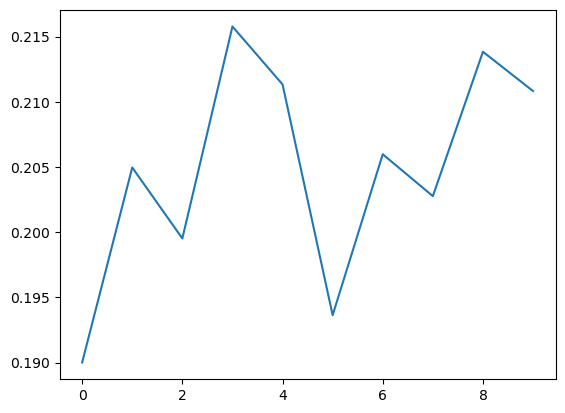

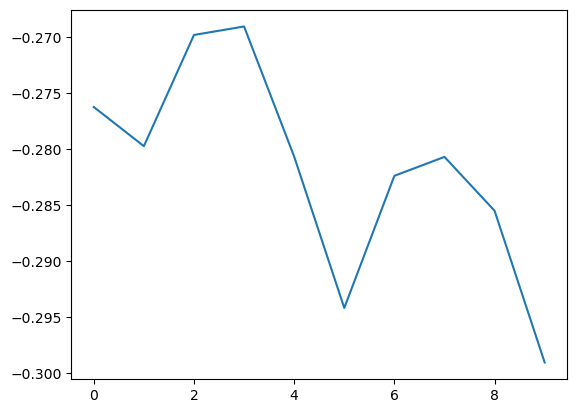

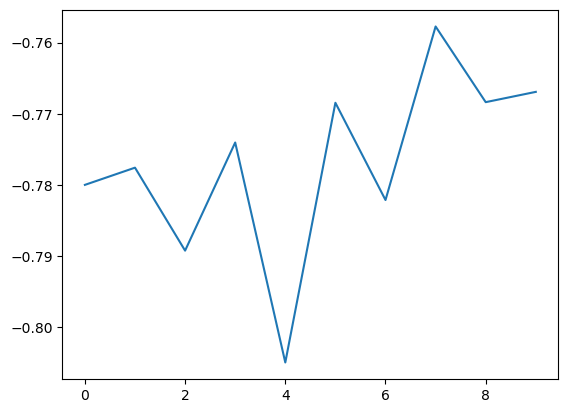

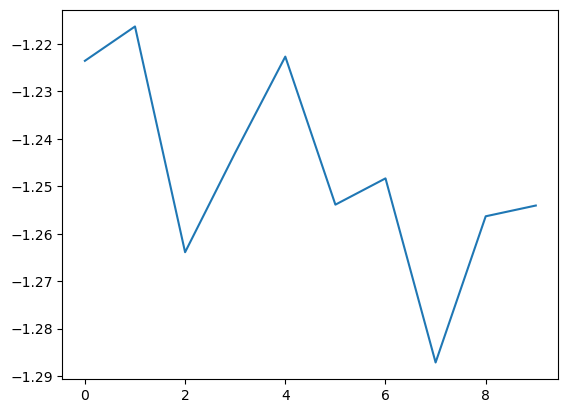

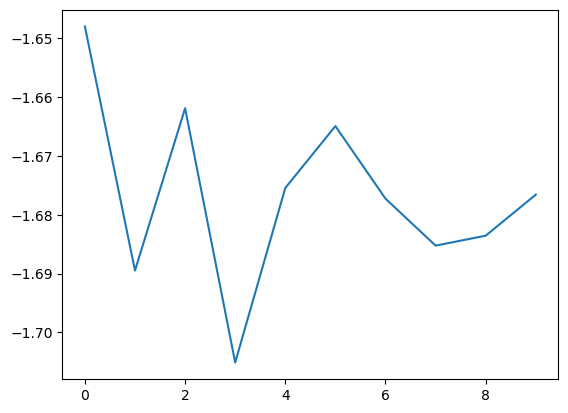

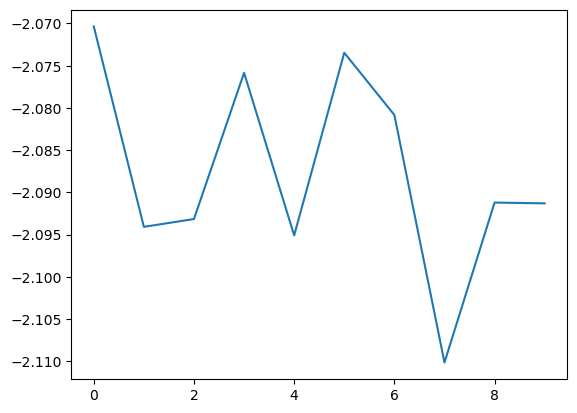

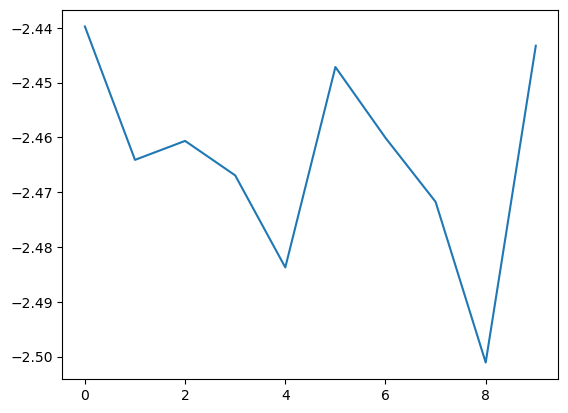

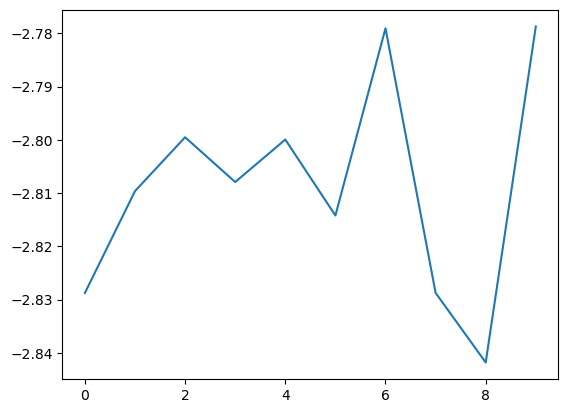

In [6]:
for dims in dimss:
    print(results[dims]['mask'])
    fig, ax = plt.subplots()
    ax.plot(results[dims]['losses'])